In [36]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import cm, colors


In [2]:
words = open('names.txt').read().splitlines()

# Get mapping between characters and numbers
chars = sorted(list(set(''.join(words) + '.')))
stoi = dict(list(zip(chars, range(len(chars)))))
itos = {v:k for k,v in stoi.items()}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [16]:
# Generate datasets

BLOCK_SIZE = 8

class WordDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

def generate_dataset(words):
    X = []
    y = []

    for word in words:
        block = [0] * BLOCK_SIZE
        for c in word + '.':
            X.append(block)
            y.append(stoi[c])
            block = block[1:] + [stoi[c]]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
    
X_all, y_all = generate_dataset(words)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1337)

train_dataset = WordDataset(X_train, y_train)
test_dataset = WordDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_loader)

2852

In [4]:
# Init old network

N_EMBEDDINGS = 10
HIDDEN_NEURONS = 200
C = torch.randn((27, N_EMBEDDINGS), requires_grad=True)
W1 = torch.randn((N_EMBEDDINGS * BLOCK_SIZE, HIDDEN_NEURONS), requires_grad=True)
b1 = torch.randn(HIDDEN_NEURONS, requires_grad=True)
W2 = torch.randn((HIDDEN_NEURONS, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

def forward(X):
    embeddings = C[X]
    x = embeddings.view(-1, N_EMBEDDINGS * BLOCK_SIZE)
    x = x @ W1 + b1
    x = torch.tanh(x)
    x = x @ W2 + b2
    return x

In [5]:
# Init torched network
class MLP(nn.Module):
    def __init__(self, n_embeddings=10, hidden_neurons=200):
        super(MLP, self).__init__()
        self.n_embeddings = n_embeddings
        
        self.embedding = nn.Embedding(27, n_embeddings)
        ##self.c = torch.randn((27, n_embeddings), requires_grad=True)
        self.fc1 = nn.Linear(n_embeddings * BLOCK_SIZE, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 27)
        
        self.bn = nn.BatchNorm1d(hidden_neurons)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(-1, self.n_embeddings * BLOCK_SIZE)
        x = self.fc1(x)
        x = self.bn(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
model = MLP(n_embeddings=10, hidden_neurons=200)
model.num_params()

22297

In [18]:
class WaveNet(nn.Module):
    def __init__(self, n_embeddings=10, hidden_neurons=200):
        super(WaveNet, self).__init__()
        self.n_embeddings = n_embeddings
        self.hidden_neurons = hidden_neurons
        
        self.embedding = nn.Embedding(27, n_embeddings)
        self.fc1 = nn.Linear(n_embeddings * 2, hidden_neurons)
        self.bn1 = nn.BatchNorm1d(hidden_neurons)
        
        self.fc2 = nn.Linear(hidden_neurons * 2, hidden_neurons)
        self.bn2 = nn.BatchNorm1d(hidden_neurons)
        
        self.fc3 = nn.Linear(hidden_neurons * 2, hidden_neurons)
        self.bn3 = nn.BatchNorm1d(hidden_neurons)
        
        self.fc4 = nn.Linear(hidden_neurons, 27)
        
        
        
    def forward(self, x):
        x = self.embedding(x)
        
        x = x.view(-1, 4, self.n_embeddings * 2)
        self.tmp = x
        x = self.fc1(x)
        x = x.swapaxes(1,2)
        x = self.bn1(x)
        x = x.swapaxes(1,2)
        x = torch.tanh(x)
        
        x = x.reshape(-1, 2, self.hidden_neurons * 2)
        x = self.fc2(x)
        x = x.swapaxes(1,2)
        x = self.bn2(x)
        x = x.swapaxes(1,2)
        x = torch.tanh(x)
        
        x = x.reshape(-1, self.hidden_neurons * 2)
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.tanh(x)
        
        x = self.fc4(x)
       
        return x
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
model = WaveNet(n_embeddings = 20, hidden_neurons=200)
model.num_params()


175767

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
lossi = []

In [42]:
# Training
model.train()
for epoch in range(10):
    print(f'{epoch=}', end=' ')
    total_loss = 0
    for X, y in train_loader:
        pred = model(X)
        loss = F.cross_entropy(pred, y)
        total_loss += loss.item()

        model.zero_grad()
        loss.backward()
        
        optimizer.step()

    total_loss /= len(train_loader)
    lossi.append(total_loss)
    print(f'{total_loss=}')

epoch=0 total_loss=2.1775547859127022
epoch=1 total_loss=2.176869030169317
epoch=2 total_loss=2.177544898480219
epoch=3 total_loss=2.1755490324774764
epoch=4 total_loss=2.1760448545510105
epoch=5 total_loss=2.17736095085552
epoch=6 total_loss=2.1770204799288955
epoch=7 total_loss=2.176344539432004
epoch=8 total_loss=2.176648127205074
epoch=9 total_loss=2.1769104978647005


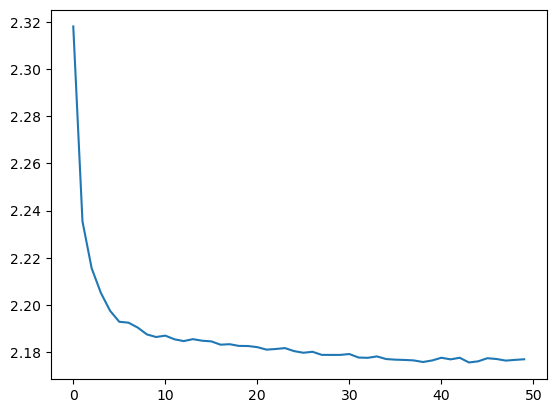

In [43]:
plt.plot(lossi)

In [41]:
optimizer.lr = 0.00001
optimizer.weight_decay=0.0001

In [44]:
model.eval()
test_loss = 0
for X, y in test_loader:
    pred = model(X)
    loss = F.cross_entropy(pred, y)
    test_loss += loss.item()
    
test_loss /= len(test_loader)
print(f'{test_loss=}')

test_loss=2.1981185169741617


In [45]:
# Predict with model
generator = torch.Generator().manual_seed(1337)

# Generate names from bigram distribution
for _ in range(10):
    out = []
    block = [0] * BLOCK_SIZE
    while True:
        pred = model(torch.tensor(block))
        probs = F.softmax(pred, dim=1)
        s = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
        out.append(s)
        block = block[1:] + [s]
        if s == 0:
            break
    print(''.join(itos[c] for c in out))

kynnale.
obagann.
evanne.
jatetton.
adiliah.
kiyaen.
nalar.
khfi.
keilei.
awyana.


(array([ 122.,  134.,  161.,  215.,  263.,  254.,  335.,  377.,  396.,
         460.,  496.,  592.,  592.,  719.,  721.,  810.,  806.,  894.,
         972.,  929., 1030., 1065., 1110., 1048., 1148., 1123., 1123.,
        1139., 1096., 1037.,  972.,  989.,  874.,  831.,  755.,  714.,
         650.,  595.,  554.,  504.,  489.,  406.,  338.,  330.,  277.,
         247.,  206.,  179.,  148.,  150.]),
 array([-10.        ,  -9.60000038,  -9.19999981,  -8.80000019,
         -8.39999962,  -8.        ,  -7.5999999 ,  -7.19999981,
         -6.80000019,  -6.4000001 ,  -6.        ,  -5.5999999 ,
         -5.19999981,  -4.80000019,  -4.4000001 ,  -4.        ,
         -3.5999999 ,  -3.20000005,  -2.79999995,  -2.4000001 ,
         -2.        ,  -1.60000002,  -1.20000005,  -0.80000001,
         -0.40000001,   0.        ,   0.40000001,   0.80000001,
          1.20000005,   1.60000002,   2.        ,   2.4000001 ,
          2.79999995,   3.20000005,   3.5999999 ,   4.        ,
          4.4000001 ,   

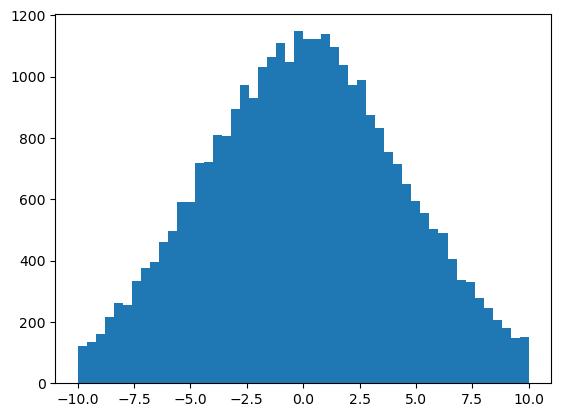

In [192]:
plt.hist(model.fc2.weight.flatten().detach().numpy(), 50, range=(-10,10))

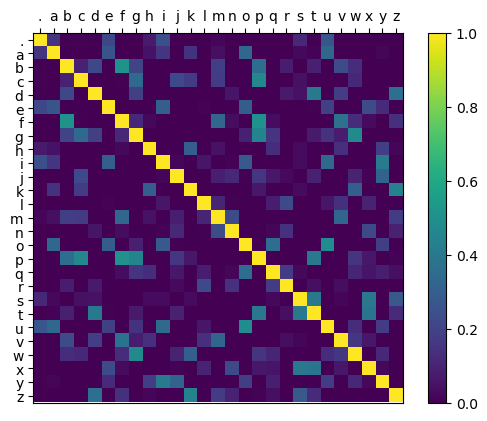

In [46]:
similarities = np.zeros((27, 27))
for c1 in range(27):
    for c2 in range(27):
        similarities[c1, c2] = F.relu(F.cosine_similarity(model.embedding.weight[c1], model.embedding.weight[c2], dim=0)).item()
        
fig, ax = plt.subplots()

plt.imshow(similarities)

ax.xaxis.tick_top()
ax.set_xticks(range(len(itos)))
ax.set_xticklabels(list(itos.values()))

ax.set_yticks(range(len(itos)))
ax.set_yticklabels(list(itos.values()))

fig.colorbar(cm.ScalarMappable(), ax=ax)

plt.show()